In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from energy_spectrum import compute_tke_spectrum
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from IPython import display
import time

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [3]:
# The data is in https://drive.google.com/file/d/1n9gjLCxzFe8N2QbHeZkDtswlSdNyJpEs/view?usp=drive_link
test_data = np.load("test_dataset.npy")
print("Test data shape: ", test_data.shape)

Test data shape:  (4, 320, 256, 256)


In [4]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.down1 = nn.Sequential(nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)

        self.middle = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.Conv2d(256, 256, 3, padding=1), nn.ReLU())

        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 2, stride=2), nn.ReLU())
        self.conv_up1 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())

        self.up2 = nn.Sequential(nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU())
        self.conv_up2 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        down1 = self.down1(x)
        pool1 = self.pool1(down1)
        down2 = self.down2(pool1)
        pool2 = self.pool2(down2)

        middle = self.middle(pool2)

        up1 = self.up1(middle)
        up1 = torch.cat((up1, down2), dim=1)
        up1 = self.conv_up1(up1)

        up2 = self.up2(up1)
        up2 = torch.cat((up2, down1), dim=1)
        up2 = self.conv_up2(up2)

        return self.final(up2)

In [6]:
'''
Reading the pretrained parameters
'''
model = SimpleUNet()
# The pretrained model is in https://drive.google.com/file/d/16W_aeHeB-yBHSFRfo1ILJh3DbahkUiRT/view?usp=drive_link
state_dict = torch.load('trained_model_unconditional.pth', map_location=torch.device('cpu'), weights_only=True)
model.load_state_dict(state_dict)
model.to(device)
model.eval();

In [76]:
def denoise(guidance, model, K, beta_min = 1e-4, beta_max = 0.02, steps=[1000], output_freq=10):
    for i in range(K):
        betas = torch.linspace(beta_min, beta_max, steps[i]).to(device)
        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)
        epsilon = torch.randn_like(guidance).to(device)
        x_t = torch.sqrt(alphas_cumprod[steps[i]-1]) * guidance + \
        torch.sqrt(1 - alphas_cumprod[steps[i]-1]) * epsilon
        for t in reversed(range(1, steps[i]+1)):
            assert x_t.shape[1] == 1, f"Error: The channel of x_t != 1."  # Make sure the input is a single channel snapshot
            if t%output_freq == 0 or t == 1:
                plt.imshow(x_t.squeeze().cpu())
                display.display(plt.gcf())
                display.clear_output(wait=True)
                time.sleep(0.01)
                
            # Calculate the parameters
            alpha_t_bar = alphas_cumprod[t-1]
            beta_t = betas[t-1]
            alpha_t = alphas[t-1]
            # Add the normalized time step (normalize by divided by the number of the total steps) as the third channel
            #nomalized_t = t / (steps)
            #time_step_channel = torch.ones_like(x_t) * nomalized_t
            #time_step_channel = time_step_channel.to(device)
            #x_t_with_conditions_and_time_step = torch.cat((x_t_with_conditions, time_step_channel), dim=1)
            #assert x_t_with_conditions_and_time_step.shape[1] == 2, f"Error: The channel of x_t_with_conditions_and_time_step != 3."


            # Predict the noise using the model
            with torch.no_grad():
                epsilon_theta = model(x_t)

            # Make sure the output of the model (the predicted noise) has a single channel
            assert epsilon_theta.shape[1] == 1, "Error: The channel of epsilon_theta != 1."
            # Calculate the mean of the previous step in the backward process of diffusion model
            mean = (1 / torch.sqrt(alpha_t)) * (x_t - (beta_t / torch.sqrt(1 - alpha_t_bar)) * epsilon_theta)
            # Add noise for all but the last step (strictly follow the algorithm)
            if t > 1:
                # z = torch.randn_like(x_t).to(device)
                z = torch.randn_like(x_t).to(device)
                x_t = mean + torch.sqrt(beta_t) * z
            else:
                x_t = mean

        guidance = x_t
        #plt.show()
    return x_t

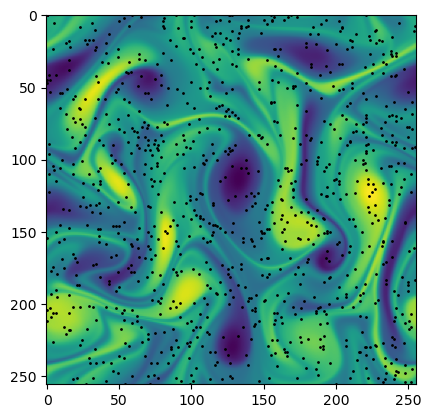

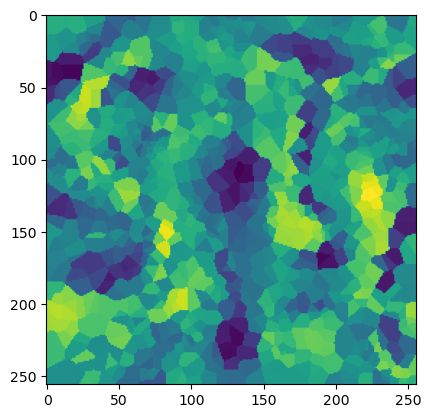

In [184]:
#Randomly choose a fixed percentage of points from the test snapshot
percentage = 1.5625
factor = percentage/100
N = int(256**2 * factor)
test_snapshot = test_data[0, 80, :, :]
nx = np.random.randint(0, 256, (N,))
ny = np.random.randint(0, 256, (N,))
sparse_measurement =  test_snapshot[nx, ny]

#Nearest neighbor interpolation
xx,yy = np.meshgrid(np.arange(256), np.arange(256))
coordinates = np.vstack((nx, ny)).T
interpolated_sparse_measurement = interpolate.griddata(coordinates, sparse_measurement, (xx,yy), method='nearest').T

#Visualize location of selected points and interpolated sparse measurements
figure,ax = plt.subplots()
figure2,ax2 = plt.subplots()
ax.imshow(test_snapshot)
mask = np.zeros((256, 256))
mask[nx, ny] = 1
ax.scatter(xx*mask, yy*mask, s=1, c="black")
ax2.imshow(interpolated_sparse_measurement)


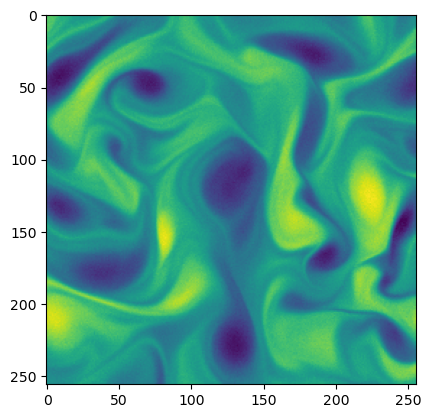

In [189]:
#Generate high fidelity data from sparse mesurements
sparse_measurement = torch.tensor(interpolated_sparse_measurement, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
K = 1
steps = np.array([200,50])
generated_image = denoise(sparse_measurement, model,steps=steps, K=K, beta_max=0.002, output_freq=10).squeeze().detach().cpu().numpy()

0.4498028843343043 0.5330681074360641
24.722932758703898


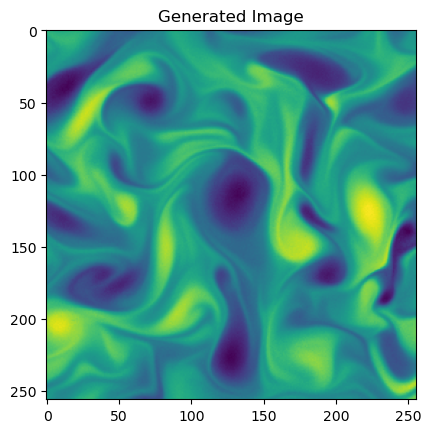

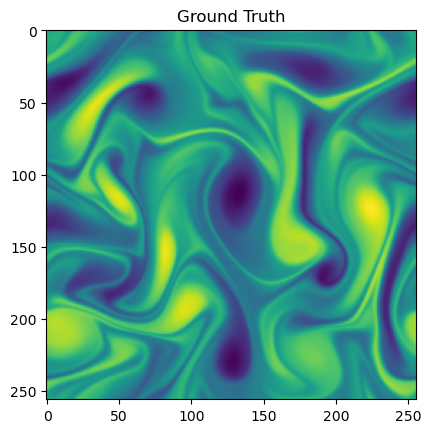

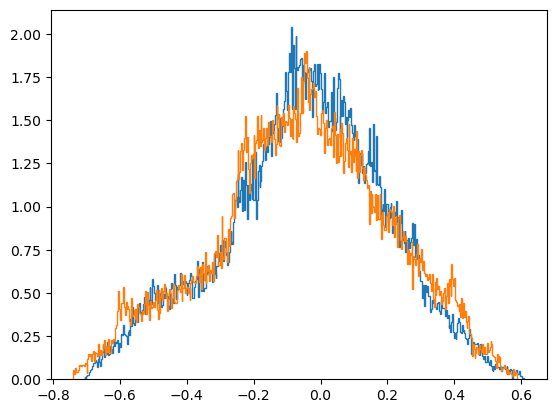

In [188]:

#Randomly choose a fixed percentage of points from the test snapshot
#percentage = 1
#factor = percentage/100
#N = int(256**2 * factor)
#test_snapshot = test_data[3, 10, :, :]
#nx = np.random.randint(0, 256, (N,))
#ny = np.random.randint(0, 256, (N,))
#sparse_measurement =  test_snapshot[nx, ny]




#Plot generated field and ground truth
figure3, ax3  = plt.subplots()
figure4, ax4 = plt.subplots()
fig5, ax5 = plt.subplots()

ax3.imshow(generated_image)
ax4.imshow(test_snapshot)
ax3.set_title("Generated Image")
ax4.set_title("Ground Truth")

#Calculate quality metrics
PSNR = peak_signal_noise_ratio(test_snapshot, generated_image, data_range=2.0)
SSIM = structural_similarity(test_snapshot, generated_image, data_range=2.0)
SSIM_Sparse = structural_similarity(test_snapshot, interpolated_sparse_measurement, data_range=2.0)


hist = ax5.hist(generated_image.flatten(), facecolor='None', edgecolor='C0', histtype='step', bins=500 , density='True')
ax5.hist(test_snapshot.flatten(),  facecolor='None', edgecolor='C1', histtype='step'  , bins=500, density='True')
dx = (np.max(generated_image) - np.min(generated_image))/500
#print(np.sum(dx * hist[0]))
print(SSIM_Sparse, SSIM)
print(PSNR)
